intermediate-ancient-high: 100%|██████████| 30/30 [01:56<00:00,  3.87s/it]


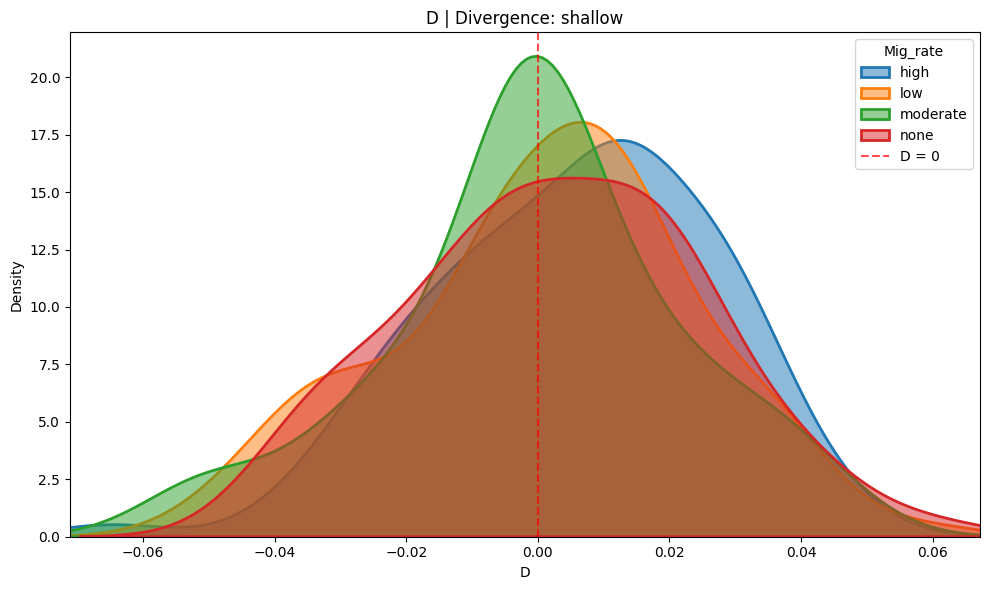

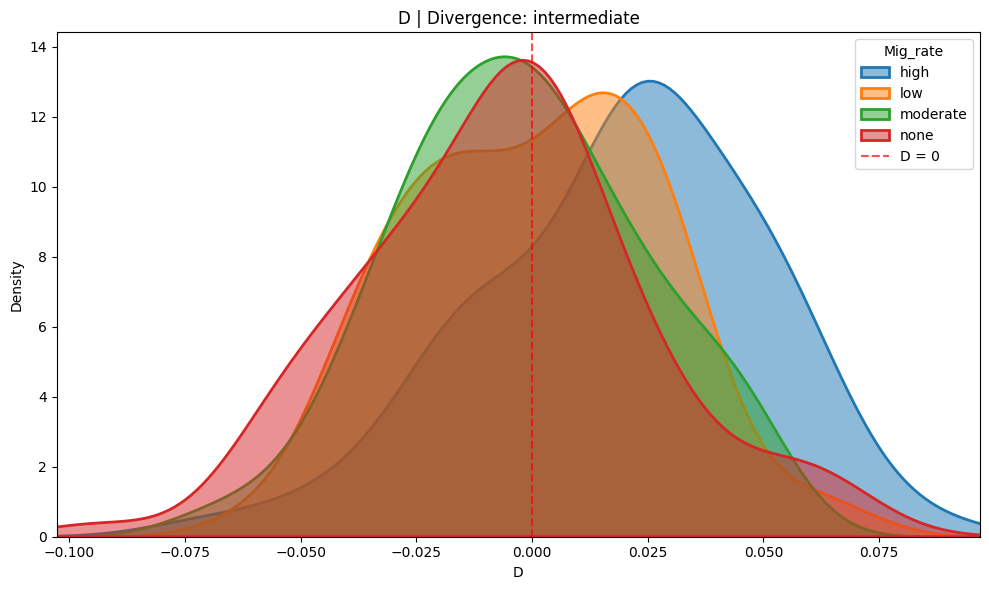

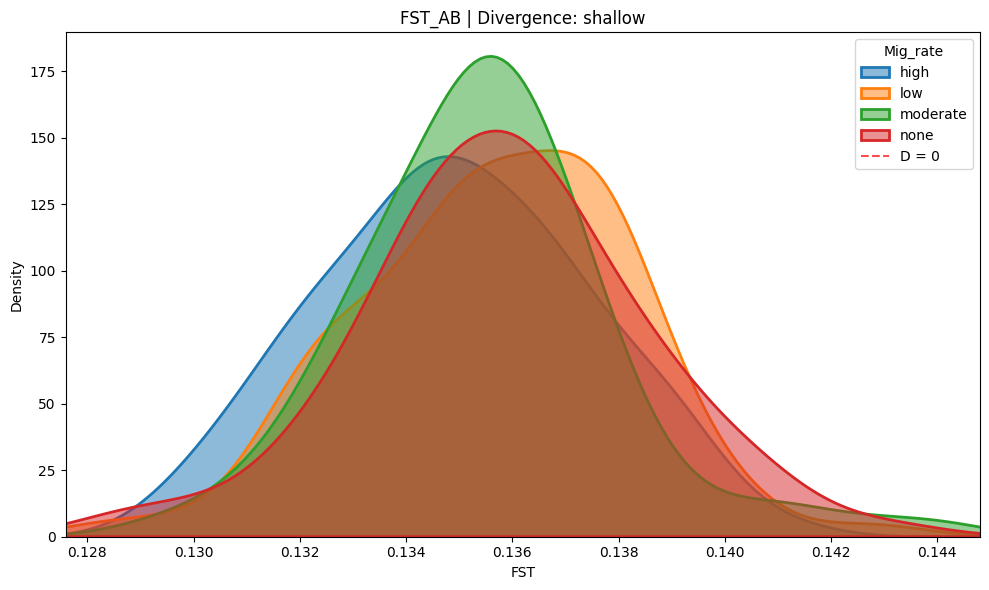

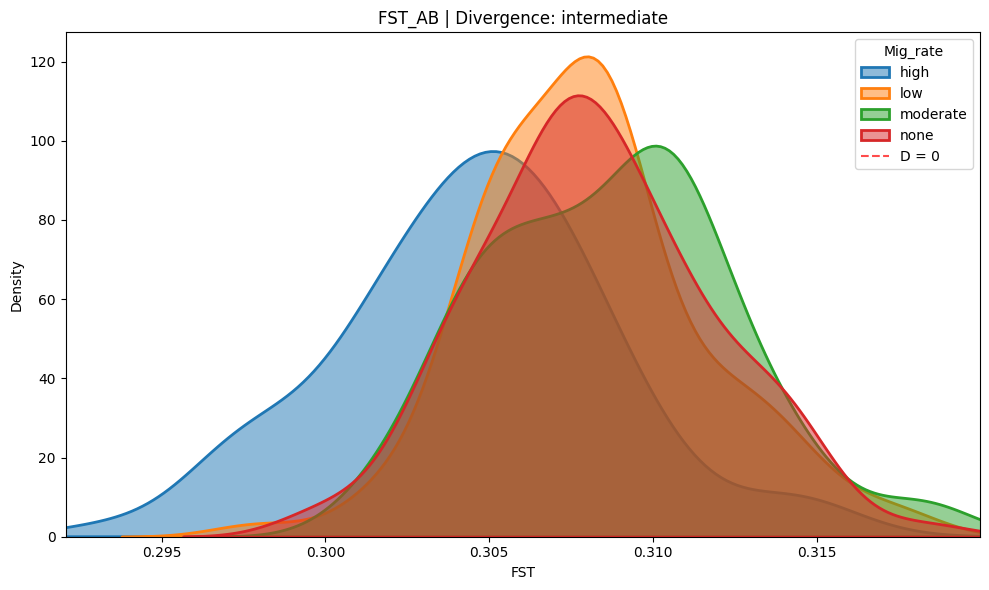

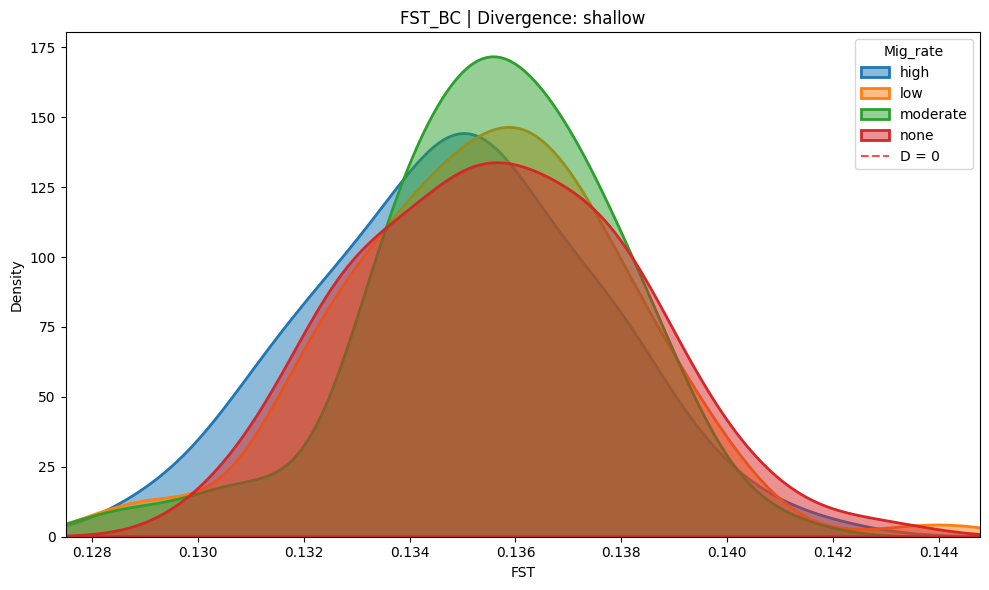

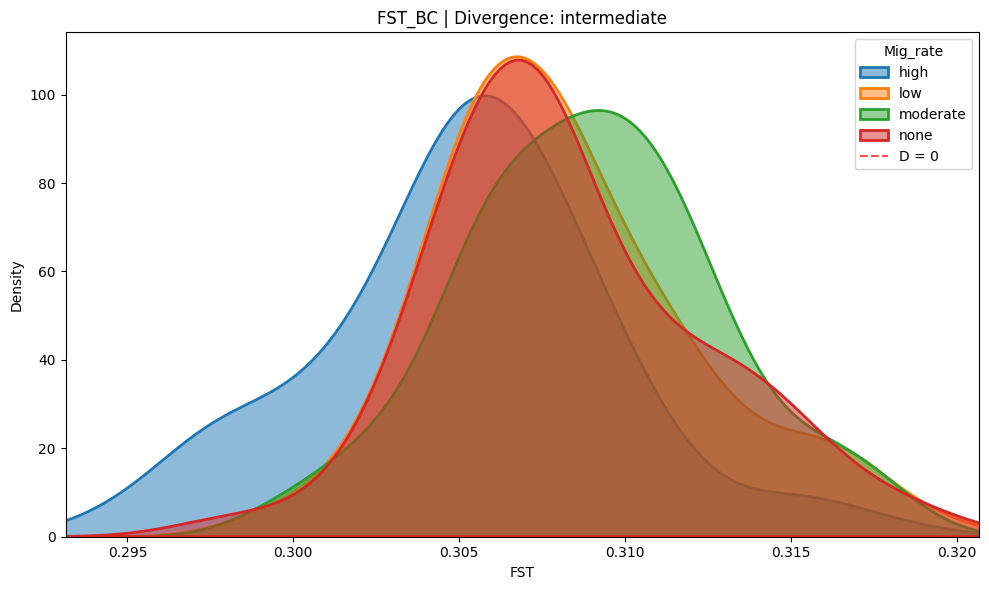

NameError: name 'ts_example' is not defined

In [1]:
# ============================================
# 3_Mixed_introgression.ipynb
# ============================================

# === Setup ===
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set working paths
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
simulations_path = os.path.join(project_root, 'simulations')
if simulations_path not in sys.path:
    sys.path.insert(0, simulations_path)

from common_utils import (
    simulate_introgression_scenario,
    calculate_d_statistic,
    calculate_fst,
    save_dataframe,
    plot_kde_distribution,
    sliding_window_d,
    sliding_window_fst
)

# === Output folders (local directory to avoid permissions issues) ===
os.makedirs("results/mixed_updated", exist_ok=True)
os.makedirs("figures/mixed_updated", exist_ok=True)

# === Parameters ===
n_replicates = 30
Ne = 200000

divergence_scenarios = {
    "shallow": (100000, 200000),
    "intermediate": (400000, 800000)
}

migration_rates = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2
}

migration_times = {
    "recent": 10000,
    "intermediate": 50000,
    "ancient": 200000
}

# === Run Simulations ===
results = []

for div_label, (div_time_abc, div_time_ab) in divergence_scenarios.items():
    for mig_time_label, mig_time in migration_times.items():
        for mig_label, mig_rate in migration_rates.items():
            for rep in tqdm(range(n_replicates), desc=f"{div_label}-{mig_time_label}-{mig_label}"):
                ts = simulate_introgression_scenario(
                    Ne=Ne,
                    div_time_ab=div_time_ab,
                    div_time_abc=div_time_abc,
                    mig_rate=mig_rate,
                    mig_time=mig_time,
                    continuous=False,
                    migration_direction="C_to_B"
                )

                d_stat, abba, baba = calculate_d_statistic(ts)
                fst_ab, fst_bc = calculate_fst(ts)

                results.append({
                    "rep": rep,
                    "divergence": div_label,
                    "mig_time": mig_time_label,
                    "mig_rate": mig_label,
                    "D": d_stat,
                    "ABBA": abba,
                    "BABA": baba,
                    "FST_AB": fst_ab,
                    "FST_BC": fst_bc
                })

# === Save Final Combined DataFrame ===
df = pd.DataFrame(results)
save_dataframe(df, "results/mixed_updated/summary.csv")


# === Smarter KDE Plots: D-statistic + FST_AB + FST_BC ===
for metric in ["D", "FST_AB", "FST_BC"]:
    for div in df["divergence"].unique():
        subset = df[df["divergence"] == div]
        
        # Extract values to determine zoomed-in xlim
        values = subset[metric].dropna()
        lower, upper = values.min(), values.max()
        margin = 0.05 * (upper - lower)  # small margin for breathing space
        xlim_range = (lower - margin, upper + margin)

        # Plot KDE using dynamically determined xlim
        plot_kde_distribution(
            data=subset,
            group_col="mig_rate",
            value_col=metric,
            title=f"{metric} | Divergence: {div}",
            xlabel=metric if not metric.startswith("FST") else "FST",
            output_path=f"figures/mixed_updated/{metric}_{div}.png",
            xlim=xlim_range
        )

# --- D-statistic windows ---
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy')

# Add horizontal lines
plt.axhline(0, color='red', linestyle='--')
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

# Auto-scale y-axis to where D-stat values are
d_margin = 0.05 * (max(d_stats) - min(d_stats))
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic (Mixed ILS + Introgression Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_example.png", dpi=300)
plt.show()

# --- FST windows ---
fst_mids, fst_vals = sliding_window_fst(ts_example)

window = 5  # smoothing window
smoothed = np.convolve(fst_vals, np.ones(window) / window, mode="same")

plt.figure(figsize=(12, 4))
plt.plot(fst_mids, fst_vals, marker='o', linestyle='-', color='orange', alpha=0.5, label="Raw")
plt.plot(fst_mids, smoothed, color='darkorange', linewidth=2, label=f"Smoothed (window={window})")
plt.axhline(np.mean(fst_vals), linestyle="--", color="gray", alpha=0.5, label="Mean FST")

# Auto-scale y-axis to where FST values are
fst_margin = 0.05 * (max(fst_vals) - min(fst_vals))
plt.ylim(min(fst_vals) - fst_margin, max(fst_vals) + fst_margin)

plt.title("Sliding Window FST between B and C (Mixed ILS + Introgression Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_fst_bc_example.png", dpi=300)
plt.show()


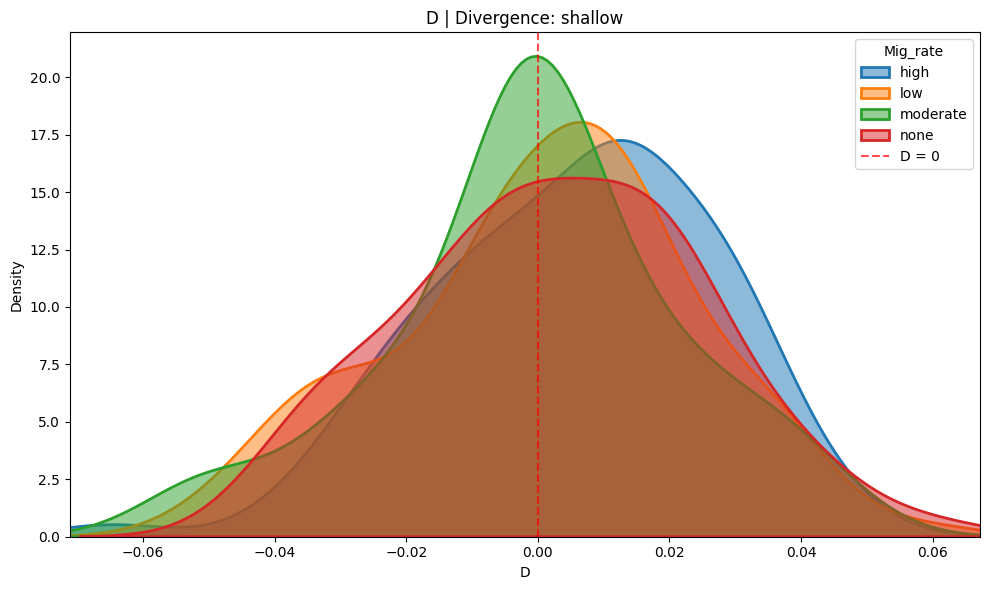

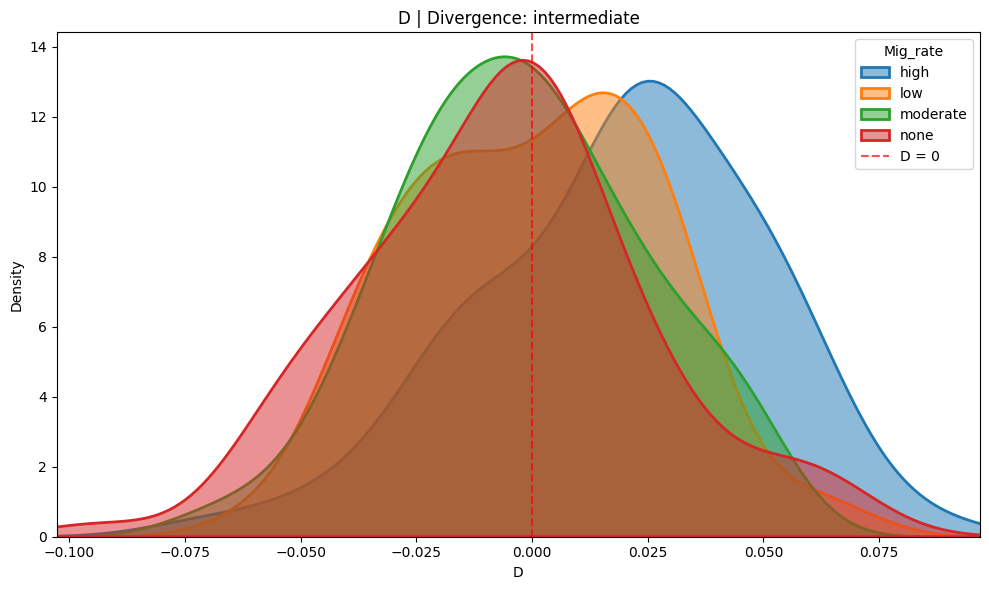

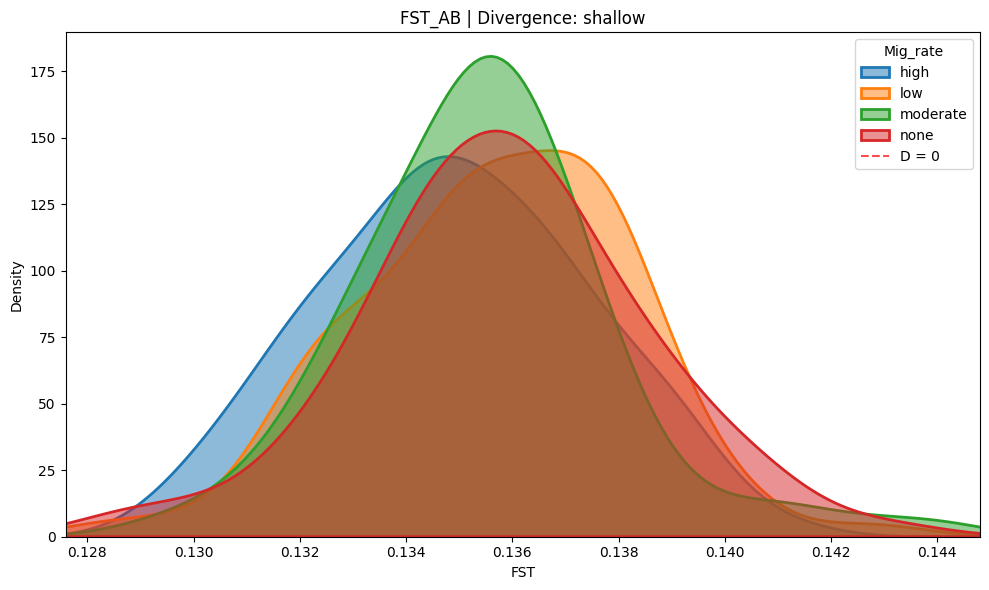

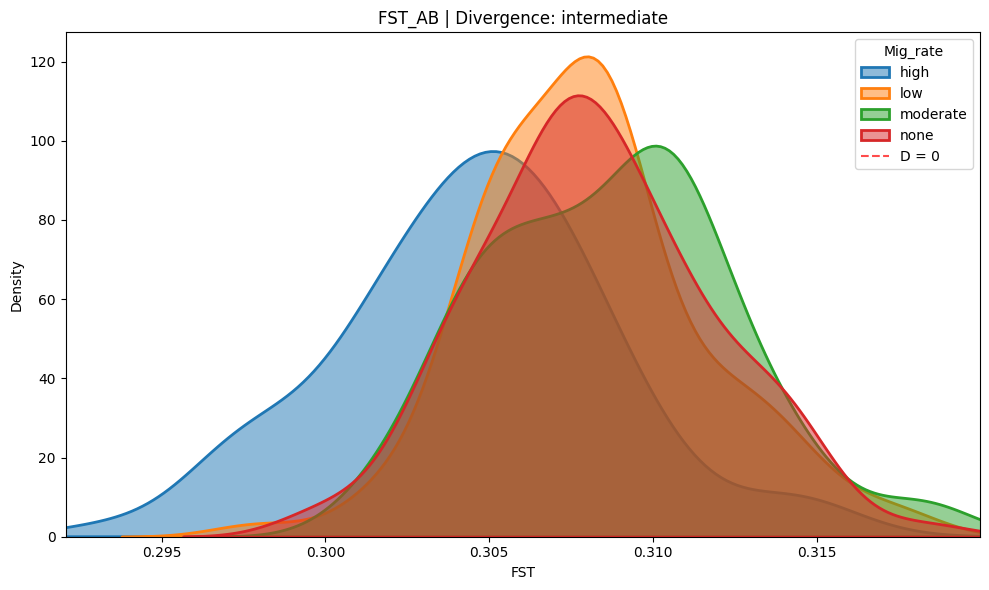

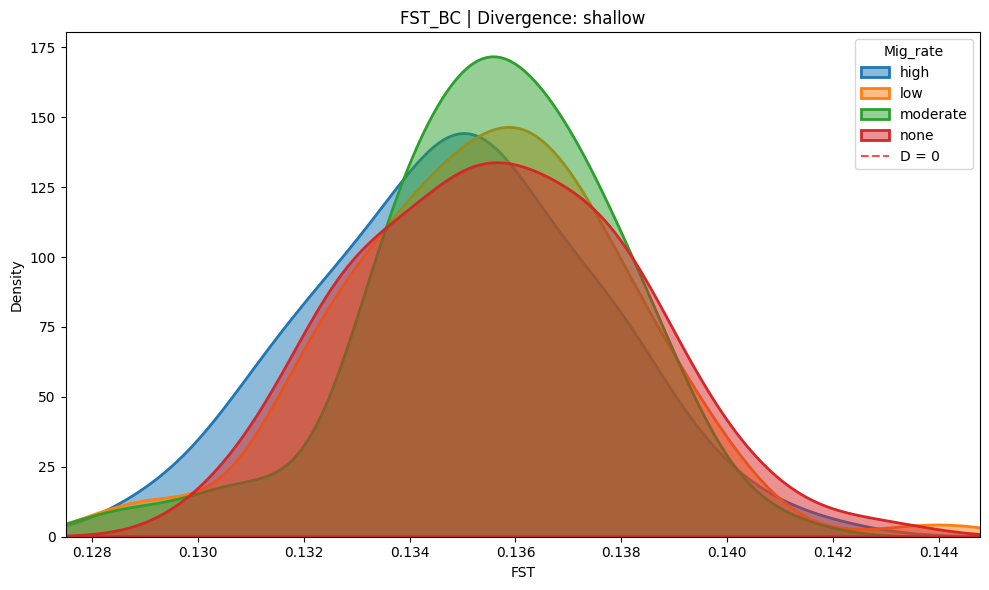

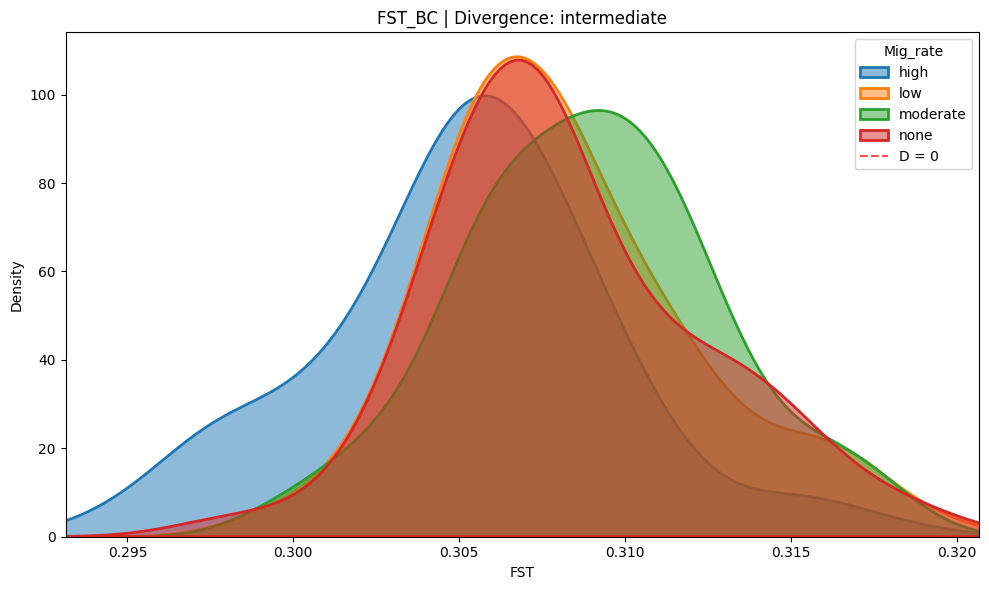

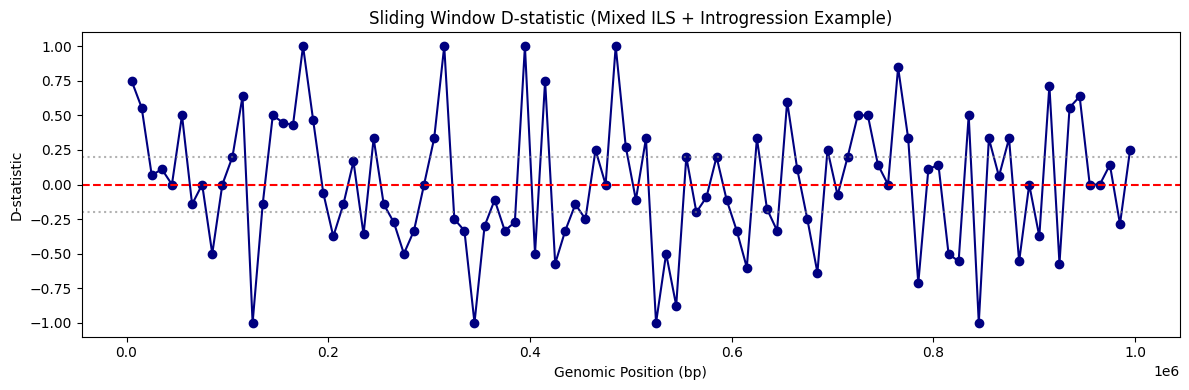

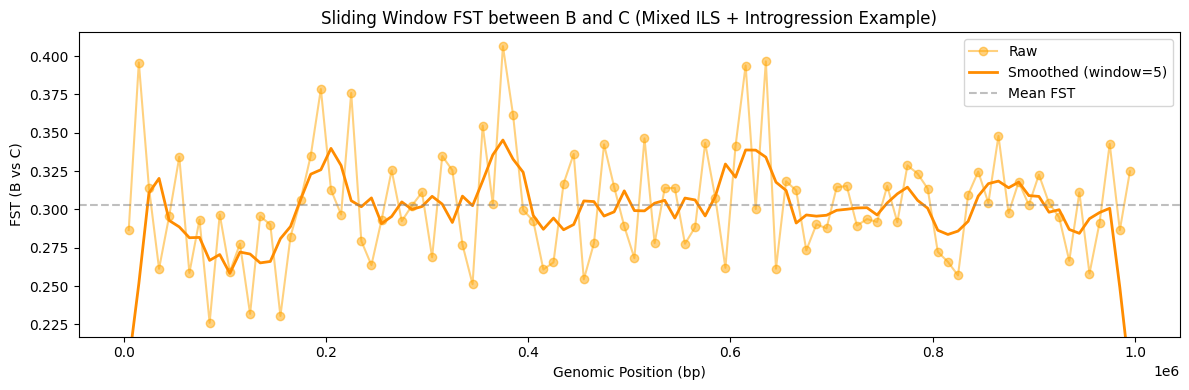

In [3]:
# === Smarter KDE Plots: D-statistic + FST_AB + FST_BC ===
for metric in ["D", "FST_AB", "FST_BC"]:
    for div in df["divergence"].unique():
        subset = df[df["divergence"] == div]
        
        # Extract values to determine zoomed-in xlim
        values = subset[metric].dropna()
        lower, upper = values.min(), values.max()
        margin = 0.05 * (upper - lower)  # small margin for breathing space
        xlim_range = (lower - margin, upper + margin)

        # Plot KDE using dynamically determined xlim
        plot_kde_distribution(
            data=subset,
            group_col="mig_rate",
            value_col=metric,
            title=f"{metric} | Divergence: {div}",
            xlabel=metric if not metric.startswith("FST") else "FST",
            output_path=f"figures/mixed_updated/{metric}_{div}.png",
            xlim=xlim_range
        )

# === Simulate one representative example for sliding window plots ===
ts_example = simulate_introgression_scenario(
    Ne=Ne,
    div_time_ab=400000,
    div_time_abc=800000,
    mig_rate=1e-2,          # High migration
    mig_time=50000,         # Intermediate time
    continuous=False,
    migration_direction="C_to_B"
)

# --- D-statistic windows ---
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy')

# Add horizontal lines
plt.axhline(0, color='red', linestyle='--')
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

# Auto-scale y-axis to where D-stat values are
d_margin = 0.05 * (max(d_stats) - min(d_stats))
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic (Mixed ILS + Introgression Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_example.png", dpi=300)
plt.show()

# --- FST windows ---
fst_mids, fst_vals = sliding_window_fst(ts_example)

window = 5  # smoothing window
smoothed = np.convolve(fst_vals, np.ones(window) / window, mode="same")

plt.figure(figsize=(12, 4))
plt.plot(fst_mids, fst_vals, marker='o', linestyle='-', color='orange', alpha=0.5, label="Raw")
plt.plot(fst_mids, smoothed, color='darkorange', linewidth=2, label=f"Smoothed (window={window})")
plt.axhline(np.mean(fst_vals), linestyle="--", color="gray", alpha=0.5, label="Mean FST")

# Auto-scale y-axis to where FST values are
fst_margin = 0.05 * (max(fst_vals) - min(fst_vals))
plt.ylim(min(fst_vals) - fst_margin, max(fst_vals) + fst_margin)

plt.title("Sliding Window FST between B and C (Mixed ILS + Introgression Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_fst_bc_example.png", dpi=300)
plt.show()
